# Purpose:
- continued from 240423_multiplane_zdrift_combined.ipynb
    - Due to too slow VScode jupyter notebook
- There is difference between the slope of expansion between GAD2-Cre and Slc17a7-Cre
    - Is this real? (any other confounding effects?)
- How much proportion of Slc17a7-Cre mice sessions can be saved from "global" online motion correction?
- How much depth difference is tolerable for hydration-related expansion?
    - For pairwise online motion correction

In [2]:
import brain_observatory_qc.pipeline_dev.scripts.depth_estimation_module as dem
from pathlib import Path
import numpy as np
import pandas as pd
import h5py
from datetime import datetime
from matplotlib import pyplot as plt
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache as bpc
from brain_observatory_qc.data_access import from_lims
from pymongo import MongoClient
from visual_behavior import database as db
from datetime import datetime
import seaborn as sns
import matplotlib as mpl
from allensdk.brain_observatory.behavior.behavior_ophys_experiment import \
    BehaviorOphysExperiment
from scipy.interpolate import interp1d

zdrift_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\ophys\zdrift')
behavior_dir = zdrift_dir / 'behavior_df'
plane_interval = 0.75

def _return_depth_zdrift_diff_pair(session_table):
    unique_regions = session_table.targeted_structure.unique()
    depth_diff = []
    zdrift_diff = []
    for region in unique_regions:
        temp_table = session_table.query('targeted_structure==@region')
        for i in range(len(temp_table)-1):
            for j in range(i+1, len(temp_table)):
                depth_diff.append(abs(temp_table.iloc[i].imaging_depth - temp_table.iloc[j].imaging_depth))
                zdrift_diff.append(abs(temp_table.iloc[i].zdrift_episodes - temp_table.iloc[j].zdrift_episodes))
    return depth_diff, zdrift_diff


def get_depth_drift_df(table):
    depth_zdrift_pair = table.groupby('ophys_session_id').apply(lambda x: _return_depth_zdrift_diff_pair(x))
    depth_drift_df = pd.DataFrame(columns=['ophys_session_id', 'depth_diff', 'zdrift_diff'])
    for i in range(len(depth_zdrift_pair)):
        temp_osid = depth_zdrift_pair.index.values[i]
        temp_depth_diff = depth_zdrift_pair.iloc[i][0]
        temp_zdrift_diff = depth_zdrift_pair.iloc[i][1]
        temp_df = pd.DataFrame({'ophys_session_id': temp_osid,
                                'depth_diff': temp_depth_diff,
                                'zdrift_diff': temp_zdrift_diff})
        depth_drift_df = pd.concat([depth_drift_df, temp_df])
    depth_drift_df = depth_drift_df.merge(table[['ophys_session_id', 'water']].drop_duplicates(), left_on='ophys_session_id',
                                            right_on='ophys_session_id', how='inner')
    return depth_drift_df

In [3]:
cc_threshold = 0.7

cache = bpc.from_lims()
table = cache.get_ophys_experiment_table(passed_only=False)

lamf_table_fn = zdrift_dir / 'multiplane_zdrift_lamf.pkl'
lamf_table = pd.read_pickle(lamf_table_fn)

lamf_table.set_index('oeid',inplace=True,drop=True)
# add mouse_id to it
lamf_table['mouse_id'] = table.loc[lamf_table.index, 'mouse_id']
lamf_table.reset_index(drop=False,inplace=True)

lamf_table['min_cc_episodes'] = lamf_table.apply(lambda x: np.min([x['cc_episodes'][0], x['cc_episodes'][-1]]), axis=1)
lamf_table['min_cc_fl'] = lamf_table.apply(lambda x: np.min(x.cc_fl), axis=1)
lamf_table['zdrift_episodes'] = lamf_table.apply(lambda x: plane_interval * (x.mpi_episodes[-1] - x.mpi_episodes[0]), axis=1)
lamf_table['zdrift_fl'] = lamf_table.apply(lambda x: plane_interval * (x.mpi_fl[1] - x.mpi_fl[0]), axis=1)

passed_osids = lamf_table.groupby('ophys_session_id').apply(lambda x: np.min(x['min_cc_episodes']) >= cc_threshold)
passed_osids = passed_osids[passed_osids]
passed_osids = passed_osids.index.values
lamf_table = lamf_table.query('ophys_session_id in @passed_osids')


vbm_table_fn = zdrift_dir / 'multiplane_zdrift_vbm.pkl'
vbm_table = pd.read_pickle(vbm_table_fn)
bad_imaging_sessions = [977760370, 1081070236, 1075872563, 906968227,
                        1088200327, 884613038, 921636320, 876303107,
                        923705570, 865024413, 958105827, 976167513, 981845703]
filtered_table = vbm_table[~vbm_table.ophys_session_id.isin(bad_imaging_sessions)]
vbm_table = filtered_table[~filtered_table.session_type.str.contains('passive') &
                              ~filtered_table.session_type.str.contains('OPHYS_7')].copy()
# add mouse IDs
vbm_table.set_index('oeid', inplace=True)
vbm_table['mouse_id'] = vbm_table.index.map(lambda x: table.loc[x].mouse_id)
vbm_table.reset_index(drop=False, inplace=True)

vbm_table['min_cc_episodes'] = vbm_table.apply(lambda x: np.min([x['cc_episodes'][0], x['cc_episodes'][-1]]), axis=1)
vbm_table['min_cc_fl'] = vbm_table.apply(lambda x: np.min(x.cc_fl), axis=1)
vbm_table['zdrift_episodes'] = vbm_table.apply(lambda x: plane_interval * (x.mpi_episodes[-1] - x.mpi_episodes[0]), axis=1)
vbm_table['zdrift_fl'] = vbm_table.apply(lambda x: plane_interval * (x.mpi_fl[1] - x.mpi_fl[0]), axis=1)

passed_osids = vbm_table.groupby('osid').apply(lambda x: np.min(x['min_cc_episodes']) >= cc_threshold)
passed_osids = passed_osids[passed_osids]
passed_osids = passed_osids.index.values
vbm_table = vbm_table.query('osid in @passed_osids')

exc_table = vbm_table[vbm_table.cre_line.str.contains('Slc17a7')].copy()

C:\Users\jinho.kim\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexes\base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)
C:\Users\jinho.kim\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexes\base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


In [37]:
lamf_table.query('config=="1x8"').ophys_session_id.unique()

array([1328518742, 1327887497, 1329565632, 1330660575, 1333363667,
       1331164473, 1331788264, 1332498813, 1332300891, 1332789629,
       1330991697, 1326437510, 1325702798, 1325496014, 1325954010,
       1326197073, 1327350251, 1326968345, 1328512625, 1327146245,
       1327592860, 1327858060, 1329555156, 1331772571, 1331156068,
       1330933579, 1332293271, 1332031199, 1332481792, 1332777799],
      dtype=int64)

In [38]:
lamf_table.query("ophys_session_id == 1328518742")

,oeid,depth,region,mpi_episodes,cc_episodes,mpi_fl,cc_fl,ophys_experiment_id,equipment_name,full_genotype,...,targeted_structure,date_of_acquisition,session_type,config,water,mouse_id,min_cc_episodes,min_cc_fl,zdrift_episodes,zdrift_fl
40,1328716814,147,VISp,"[33, 34, 34, 34, 35, 38]","[0.8919560658157397, 0.8867013558867243, 0.915...","[32, 40]","[0.9116656663348747, 0.9398295119764221]",1.328717e+09,MESO.2,Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...,...,VISp,2024-02-05 17:58:20.651,TRAINING_1_gratings,1x8,1.205,710343,0.891956,0.911666,3.75,6.00
41,1328716811,91,VISp,"[31, 33, 34, 35, 36, 38]","[0.8700162798892848, 0.8730033797530656, 0.894...","[31, 40]","[0.8002259032059129, 0.9019000876186922]",1.328717e+09,MESO.2,Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...,...,VISp,2024-02-05 17:58:20.651,TRAINING_1_gratings,1x8,1.205,710343,0.870016,0.800226,5.25,6.75
42,1328716810,374,VISp,"[47, 46, 44, 39, 38, 41]","[0.8746962289456329, 0.9013832951030586, 0.931...","[47, 42]","[0.8571442222693011, 0.94793266183457]",1.328717e+09,MESO.2,Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...,...,VISp,2024-02-05 17:58:20.651,TRAINING_1_gratings,1x8,1.205,710343,0.874696,0.857144,-4.50,-3.75
43,1328716817,190,VISp,"[34, 34, 35, 33, 34, 36]","[0.8331513279548856, 0.8234591551987483, 0.871...","[34, 39]","[0.854855318892959, 0.9320150939299193]",1.328717e+09,MESO.2,Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...,...,VISp,2024-02-05 17:58:20.651,TRAINING_1_gratings,1x8,1.205,710343,0.833151,0.854855,1.50,3.75
44,1328716819,236,VISp,"[39, 40, 39, 38, 37, 38]","[0.8732185704802812, 0.8740378860145601, 0.918...","[38, 39]","[0.8759130169082577, 0.9565333208172556]",1.328717e+09,MESO.2,Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...,...,VISp,2024-02-05 17:58:20.651,TRAINING_1_gratings,1x8,1.205,710343,0.873219,0.875913,-0.75,0.75
45,1328716816,294,VISp,"[44, 43, 40, 38, 37, 38]","[0.8551337795478409, 0.8812574708137159, 0.912...","[43, 38]","[0.8211098672032272, 0.9417696239595308]",1.328717e+09,MESO.2,Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...,...,VISp,2024-02-05 17:58:20.651,TRAINING_1_gratings,1x8,1.205,710343,0.855134,0.821110,-4.50,-3.75
46,1328716808,42,VISp,"[30, 32, 35, 38, 39, 39]","[0.8296235301538895, 0.8274145928151774, 0.787...","[30, 40]","[0.7250000181629395, 0.745055473754018]",1.328717e+09,MESO.2,Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...,...,VISp,2024-02-05 17:58:20.651,TRAINING_1_gratings,1x8,1.205,710343,0.829624,0.725000,6.75,7.50
47,1328716813,328,VISp,"[49, 47, 44, 39, 38, 39]","[0.9059923947817183, 0.9259757814561159, 0.933...","[50, 39]","[0.870694808282846, 0.9336820241453198]",1.328717e+09,MESO.2,Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...,...,VISp,2024-02-05 17:58:20.651,TRAINING_1_gratings,1x8,1.205,710343,0.905992,0.870695,-7.50,-8.25


In [61]:
exc_water_table.full_genotype.unique()

array(['Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt'],
      dtype=object)

In [24]:
num_epochs = 5
max_timepoint = num_epochs * 600 # in s
exc_water_table = exc_table.query('water >= 0.6').copy()
exc_water_table['zdrift_episodes'] = exc_water_table.apply(lambda x: plane_interval * (x.mpi_episodes[num_epochs-1] - x.mpi_episodes[0]), axis=1)
gad2_water_table = lamf_table.query('water >= 0.6').copy()
gad2_water_table['zdrift_episodes'] = gad2_water_table.apply(lambda x: plane_interval * (x.mpi_episodes[num_epochs-1] - x.mpi_episodes[0]), axis=1)

exc_water_depth_zdrift = get_depth_drift_df(exc_water_table)
gad2_water_depth_zdrift = get_depth_drift_df(gad2_water_table)


In [16]:
water_timepoint_df = pd.DataFrame(columns=['ophys_session_id', 'acc_water'])
osids = np.union1d(exc_water_depth_zdrift.ophys_session_id.unique(),
                   gad2_water_depth_zdrift.ophys_session_id.unique())
for osid in osids:
    fn = behavior_dir / f'osid_{osid}_rewards.pkl'
    rewards_df = pd.read_pickle(fn)
    max_timestamps = rewards_df.timestamps.max()
    if max_timestamps >= max_timepoint:
        max_timepoint_ind = np.where(rewards_df.timestamps.values >= max_timepoint)[0][0]
        water_timepoint = rewards_df.acc_volume.values[max_timepoint_ind]
    else:
        water_timepoint = rewards_df.acc_volume.max()
    
    temp_df = pd.DataFrame({'ophys_session_id': osid,
                            'acc_water': water_timepoint},
                            index=[0])
    water_timepoint_df = pd.concat([water_timepoint_df, temp_df])


In [25]:
water_div_interval = 0.2

ophys_session_types = ['TRAINING_5_images_A_epilogue',
       'TRAINING_5_images_A_handoff_ready', 'OPHYS_4_images_B']
ophys_osids = lamf_table.query('session_type in @ophys_session_types').ophys_session_id.unique()

gad2_water_depth_zdrift = pd.merge(gad2_water_depth_zdrift, water_timepoint_df,
                                   left_on='ophys_session_id',
                                   right_on='ophys_session_id',
                                   how='inner')
gad2_water_depth_zdrift['water_div'] = gad2_water_depth_zdrift.acc_water.apply(lambda x: np.round((x//water_div_interval + 1)*water_div_interval,1))
gad2_water_depth_zdrift['depth_diff'] = gad2_water_depth_zdrift.depth_diff.values.astype(float)
gad2_water_depth_zdrift = gad2_water_depth_zdrift.query('ophys_session_id in @ophys_osids').copy()

exc_water_depth_zdrift = pd.merge(exc_water_depth_zdrift, water_timepoint_df,
                                   left_on='ophys_session_id',
                                   right_on='ophys_session_id',
                                   how='inner')
exc_water_depth_zdrift['water_div'] = exc_water_depth_zdrift.acc_water.apply(lambda x: np.round((x//water_div_interval + 1)*water_div_interval,1))
exc_water_depth_zdrift['depth_diff'] = exc_water_depth_zdrift.depth_diff.values.astype(float)



In [26]:
exc_water_depth_zdrift

,ophys_session_id,depth_diff,zdrift_diff,water,acc_water,water_div
0,880709154,225.0,2.25,0.935,0.914,1.0
1,880709154,75.0,0.75,0.935,0.914,1.0
2,880709154,150.0,1.50,0.935,0.914,1.0
3,880709154,150.0,3.00,0.935,0.914,1.0
4,880709154,75.0,0.75,0.935,0.914,1.0
...,...,...,...,...,...,...
295,1085718692,100.0,1.50,0.774,0.578,0.6
296,1085718692,165.0,2.25,0.774,0.578,0.6
297,1085718692,200.0,3.75,0.774,0.578,0.6
298,1085718692,265.0,4.50,0.774,0.578,0.6


In [21]:
np.sort(gad2_water_depth_zdrift.water_div.unique())

array([0.9, 1.2])

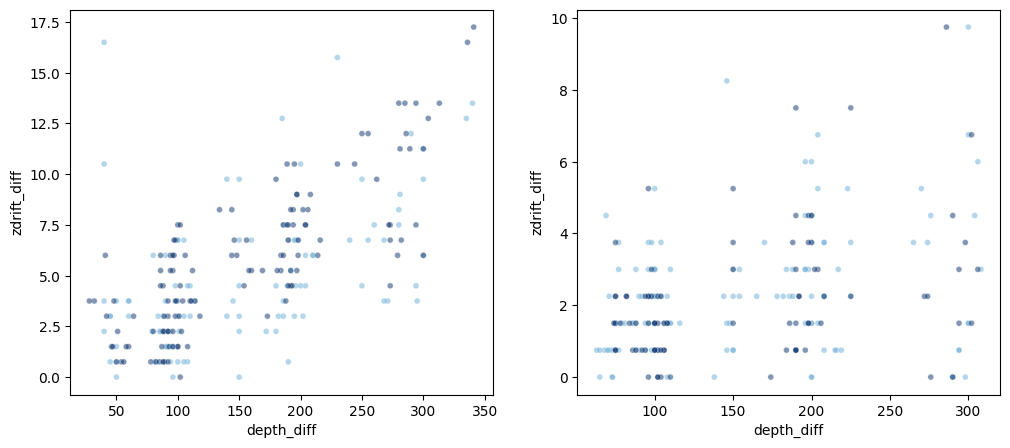

In [31]:
num_water_div = len(gad2_water_depth_zdrift.water_div.unique())
colors = mpl.cm.get_cmap('Blues')
fig, ax = plt.subplots(1,2, figsize=(12,5))
for wi, water in enumerate(np.sort(gad2_water_depth_zdrift.water_div.unique())):
    temp_df = gad2_water_depth_zdrift.query('water_div==@water')
    sns.scatterplot(temp_df, x='depth_diff', y='zdrift_diff', ax=ax[0], 
                color=colors((wi+1)/num_water_div),
                alpha=0.5, size=1, label=None, legend=False,
                )
for wi, water in enumerate(np.sort(gad2_water_depth_zdrift.water_div.unique())):
    temp_df = exc_water_depth_zdrift.query('water_div==@water')
    sns.scatterplot(temp_df, x='depth_diff', y='zdrift_diff', ax=ax[1], 
                color=colors((wi+1)/num_water_div),
                alpha=0.5, size=1, label=None, legend=False,
                )


# Correlation coefficient example

In [39]:
osid = 1327887497
oeids = from_lims.get_ophys_experiment_ids_for_ophys_session_id(osid)


In [60]:
lamf_table.full_genotype.unique()

array(['Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT2L-GC7s-ICF-IRES-tTA2)-hyg/wt'],
      dtype=object)

In [40]:
lamf_table.query("ophys_session_id==@osid")

,oeid,depth,region,mpi_episodes,cc_episodes,mpi_fl,cc_fl,ophys_experiment_id,equipment_name,full_genotype,...,targeted_structure,date_of_acquisition,session_type,config,water,mouse_id,min_cc_episodes,min_cc_fl,zdrift_episodes,zdrift_fl
48,1328083433,234,VISp,"[45, 43, 41, 37, 37, 38]","[0.9176457915671353, 0.9370546180610916, 0.936...","[45, 39]","[0.894637650787296, 0.9440392747151182]",1.328083e+09,MESO.2,Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...,...,VISp,2024-02-02 19:15:00.873,TRAINING_1_gratings,1x8,1.25,710343,0.917646,0.894638,-5.25,-4.50
49,1328083421,26,VISp,"[31, 32, 34, 36, 37, 37]","[0.7309919813986805, 0.763618543532189, 0.7934...","[27, 37]","[0.6562607144386409, 0.8895366562111633]",1.328083e+09,MESO.2,Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...,...,VISp,2024-02-02 19:15:00.873,TRAINING_1_gratings,1x8,1.25,710343,0.730992,0.656261,4.50,7.50
50,1328083423,366,VISp,"[56, 52, 46, 43, 39, 41]","[0.887057219517947, 0.903595877740064, 0.92706...","[56, 41]","[0.8855382689575799, 0.9411801695190986]",1.328083e+09,MESO.2,Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...,...,VISp,2024-02-02 19:15:00.873,TRAINING_1_gratings,1x8,1.25,710343,0.887057,0.885538,-11.25,-11.25
51,1328083427,133,VISp,"[36, 37, 36, 36, 37, 37]","[0.8198960440872672, 0.8344705540283731, 0.861...","[33, 40]","[0.8120406324522245, 0.8935517147965204]",1.328083e+09,MESO.2,Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...,...,VISp,2024-02-02 19:15:00.873,TRAINING_1_gratings,1x8,1.25,710343,0.819896,0.812041,0.75,5.25
52,1328083431,182,VISp,"[41, 40, 38, 38, 38, 39]","[0.8276283010181691, 0.8525850151363294, 0.878...","[40, 40]","[0.8146165543573761, 0.8724151422716837]",1.328083e+09,MESO.2,Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...,...,VISp,2024-02-02 19:15:00.873,TRAINING_1_gratings,1x8,1.25,710343,0.827628,0.814617,-1.50,0.00
53,1328083429,286,VISp,"[50, 47, 43, 40, 37, 39]","[0.8763048012126301, 0.8976579967270115, 0.917...","[50, 40]","[0.8654577633078918, 0.9349351875424866]",1.328083e+09,MESO.2,Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...,...,VISp,2024-02-02 19:15:00.873,TRAINING_1_gratings,1x8,1.25,710343,0.876305,0.865458,-8.25,-7.50
54,1328083424,78,VISp,"[31, 35, 36, 36, 38, 40]","[0.8054587467274777, 0.8414852555858393, 0.858...","[29, 41]","[0.7790380688587594, 0.886912975496903]",1.328083e+09,MESO.2,Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...,...,VISp,2024-02-02 19:15:00.873,TRAINING_1_gratings,1x8,1.25,710343,0.805459,0.779038,6.75,9.00
55,1328083426,334,VISp,"[55, 52, 46, 43, 39, 39]","[0.9229806454305591, 0.9307622243499786, 0.929...","[54, 41]","[0.9090202468999017, 0.9300045976288732]",1.328083e+09,MESO.2,Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...,...,VISp,2024-02-02 19:15:00.873,TRAINING_1_gratings,1x8,1.25,710343,0.922981,0.909020,-12.00,-9.75


In [43]:
oeid = 1328083421
ocid = from_lims.get_ophys_container_id_for_ophys_experiment_id(oeid)
data_dir = zdrift_dir / f'container_{ocid}' / f'experiment_{oeid}' 

zdrift_fn = data_dir / f'{oeid}_zdrift_ref_{oeid}.h5'
with h5py.File(zdrift_fn, 'r') as h:
    print(h.keys())
    # zdrift = h['data'][()]
    matched_plane_indices = h['matched_plane_indices'][()]
    corrcoef = h['corrcoef'][()]
    segment_fov_registered = h['segment_fov_registered'][()]
    translation_shift = h['translation_shift'][()]
    rigid_tmat = h['rigid_tmat'][()]
    ref_zstack_crop = h['ref_zstack_crop'][()]


<KeysViewHDF5 ['corrcoef', 'corrcoef_pre', 'matched_plane_indices', 'ops', 'ref_oeid', 'ref_zstack_crop', 'rigid_tmat', 'segment_fov_registered', 'segment_fov_registered_pre', 'translation_shift']>


Text(0, 0.5, 'Correlation coefficient')

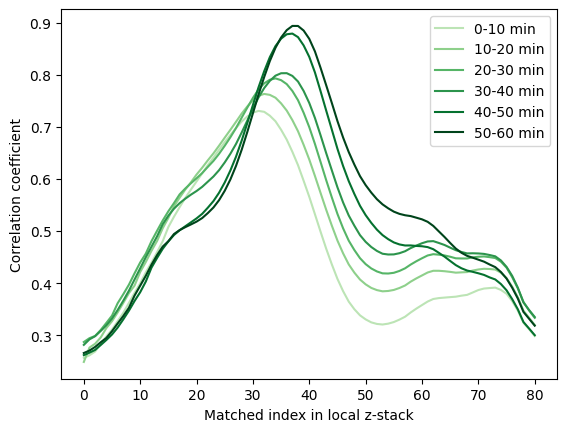

In [50]:
colors = mpl.cm.get_cmap('Greens')
fig, ax = plt.subplots()
for i in range(corrcoef.shape[0]):
    ax.plot(corrcoef[i,:], label=f'{i*10}-{(i+1)*10} min',
            color=colors((i+2)/(corrcoef.shape[0]+1)))
ax.legend()
ax.set_xlabel('Matched index in local z-stack')
ax.set_ylabel('Correlation coefficient')

# omFISH data

C:\Users\jinho.kim\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexes\base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


Text(0.5, 1.0, 'omFISH (no water restriction)')

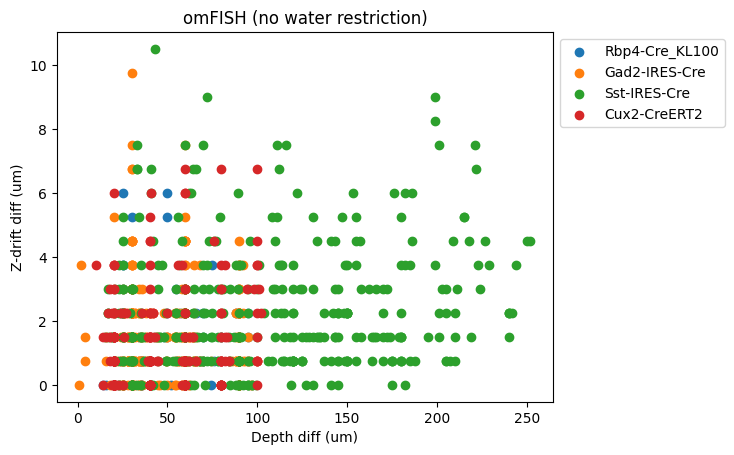

In [59]:
omfish_fn = zdrift_dir / 'multiplane_zdrift_omfish.pkl'
omfish_table = pd.read_pickle(omfish_fn)
omfish_table['osid'] = omfish_table['osid'].values.astype(int)
# removing single session case
omfish_table = omfish_table[~((omfish_table.cre_line=='Gad2-IRES-Cre') & (omfish_table.config=='1x8'))]
# set index with oeid
omfish_table.set_index('oeid', inplace=True)
# adding mouse_id
omfish_table.loc[:,'mouse_id'] = omfish_table.index.map(lambda x: table.loc[x].mouse_id)
omfish_table.groupby(['full_genotype', 'config']).apply(lambda x: len(x.mouse_id.unique()))

cc_threshold = 0.7
omfish_table['episode_drift'] = omfish_table.apply(lambda x: (x.mpi_episodes[-1] - x.mpi_episodes[0]) * 0.75, axis=1)
omfish_table['min_cc_episodes'] = omfish_table.apply(lambda x: np.min(x['cc_episodes']), axis=1)
passed_osids = omfish_table.groupby('osid').apply(lambda x: np.min(x['min_cc_episodes']) >= cc_threshold)
passed_osids = passed_osids[passed_osids]
passed_osids = passed_osids.index.values
error_osids = [1311457885, 1209100658, 1217194411, 1217152913, 1223679413]
omfish_table = omfish_table.query('osid in @passed_osids and osid not in @error_osids')

omfish_table['zdrift_episodes'] = omfish_table.apply(lambda x: (x.mpi_episodes[-1] - x.mpi_episodes[0]) * 0.75, axis=1)
cre_lines = omfish_table.cre_line.unique()
fig, ax = plt.subplots()
for crei, cre_line in enumerate(cre_lines):
    # cre_table = omfish_table.query('cre_line==@cre_line and targeted_structure=="VISl"')
    # depth_zdrift_pair = cre_table.groupby('osid').apply(lambda x: _return_depth_zdrift_diff_pair(x))
    cre_table = omfish_table.query('cre_line==@cre_line')
    depth_zdrift_pair = cre_table.groupby(['osid', 'targeted_structure']).apply(lambda x: _return_depth_zdrift_diff_pair(x))
    
    for i in range(len(depth_zdrift_pair)):
        depth_diff = depth_zdrift_pair.iloc[i][0]
        zdrift_diff = depth_zdrift_pair.iloc[i][1]
        if i == 0:
            ax.scatter(depth_diff, zdrift_diff, color=f'C{crei}', label=cre_line)
        else:
            ax.scatter(depth_diff, zdrift_diff, color=f'C{crei}')
ax.set_xlabel('Depth diff (um)')
ax.set_ylabel('Z-drift diff (um)')
ax.legend(loc='upper left', bbox_to_anchor=(1,1))
ax.set_title('omFISH (no water restriction)')


In [53]:
omfish_table.targeted_structure.unique()

array(['VISp', 'VISl'], dtype=object)

In [54]:
cre_lines

array(['Rbp4-Cre_KL100', 'Gad2-IRES-Cre', 'Sst-IRES-Cre', 'Cux2-CreERT2'],
      dtype=object)

In [55]:
cre_line = 'Gad2-IRES-Cre'
cre_table = omfish_table.query('cre_line==@cre_line').copy()
cre_table.targeted_structure.unique()

array(['VISp', 'VISl'], dtype=object)

Text(0.5, 0, 'Z-drift (um)')

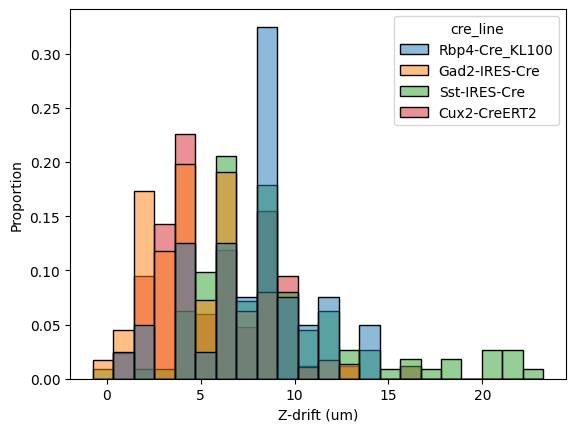

In [79]:
bins = np.linspace(0,26,13)
fig, ax = plt.subplots()
# for cre_line in cre_lines:
#     zdrift = omfish_table.query('cre_line==@cre_line').zdrift_episodes.values
#     zdrift_density = np.histogram(zdrift, bins=bins)[0] / len(zdrift)
#     ax.plot(bins[:-1], zdrift_density)
    
    # ax.hist(zdrift, bins=bins, label=cre_line,
    #         alpha=0.5)
sns.histplot(omfish_table, x='zdrift_episodes', hue='cre_line',
             stat='proportion', ax=ax, common_norm=False)
# ax.legend()
ax.set_xlabel('Z-drift (um)')
# omfish_table['zdrift_episodes'].hist()


In [80]:
omfish_table.groupby('cre_line').mean('zdrift_episodes')

,osid,ophys_experiment_id,ophys_session_id,imaging_depth,episode_drift,min_cc_episodes,zdrift_episodes
cre_line,,,,,,,
Cux2-CreERT2,1.230202e+09,1.230433e+09,1.230202e+09,229.726190,5.687500,0.947674,5.687500
Gad2-IRES-Cre,1.179895e+09,1.180051e+09,1.179895e+09,224.486111,4.768229,0.875126,4.768229
Rbp4-Cre_KL100,1.303008e+09,1.303165e+09,1.303008e+09,317.225000,7.743750,0.922462,7.743750
Sst-IRES-Cre,1.326331e+09,1.326471e+09,1.326331e+09,174.812500,9.140625,0.850562,9.140625


In [63]:
omfish_table['zdrift_episodes'].mean()

6.077290076335878

In [83]:
depth_zdrift_pair

osid        targeted_structure
1211246938  VISp                  ([40, 80, 60, 20, 100, 40, 20, 20, 60, 20, 60,...
1214406353  VISp                  ([64, 40, 22, 18, 80, 24, 42, 82, 16, 18, 58, ...
1214732993  VISp                  ([60, 20, 20, 80, 40, 40, 80, 20, 20, 40, 60, ...
1216027197  VISp                  ([20, 82, 19, 42, 62, 102, 39, 62, 82, 63, 40,...
1216823133  VISp                  ([60, 20, 80, 39, 20, 40, 20, 21, 80, 60, 19, ...
1216969462  VISp                  ([60, 20, 80, 40, 20, 80, 20, 20, 40, 100, 60,...
1217001280  VISp                  ([20, 60, 40, 20, 40, 80, 20, 40, 60, 100, 40,...
1223409259  VISp                  ([20, 60, 80, 40, 20, 40, 60, 20, 40, 20, 20, ...
1229640845  VISp                  ([101, 84, 18, 59, 45, 17, 83, 42, 56, 66, 25,...
1229863602  VISp                  ([58, 36, 14, 26, 40, 94, 44, 84, 18, 50, 10, ...
1257527048  VISp                  ([40, 60, 20, 80, 20, 20, 20, 40, 60, 40, 20, ...
1258091992  VISp                  ([100, 80, 

In [ ]:
omfish_depth_drift_df = pd.DataFrame(columns=['ophys_session_id', 'depth_diff', 'zdrift_diff', 'cre_line'])
for i in range(len(depth_zdrift_pair)):
    temp_osid = depth_zdrift_pair.index.values[i]
    temp_depth_diff = depth_zdrift_pair.iloc[i][0]
    temp_zdrift_diff = depth_zdrift_pair.iloc[i][1]
    temp_df = pd.DataFrame({'ophys_session_id': temp_osid,
                            'depth_diff': temp_depth_diff,
                            'zdrift_diff': temp_zdrift_diff})
    depth_drift_df = pd.concat([depth_drift_df, temp_df])
depth_drift_df = depth_drift_df.merge(lamf_table[['ophys_session_id', 'water']].drop_duplicates(), left_on='ophys_session_id',
                                        right_on='ophys_session_id', how='inner')


In [85]:
cre_line

'Rbp4-Cre_KL100'

In [86]:
temp_osid

(1288252885, 'VISp')

In [95]:
depth_bins = np.linspace(25,275,6)
omfish_depth_drift_df = pd.DataFrame(columns=['ophys_session_id', 'depth_diff', 'zdrift_diff', 'cre_line'])

cre_lines = omfish_table.cre_line.unique()

for crei, cre_line in enumerate(cre_lines):
    cre_table = omfish_table.query('cre_line==@cre_line')
    depth_zdrift_pair = cre_table.groupby('osid').apply(lambda x: _return_depth_zdrift_diff_pair(x))
    
    for i in range(len(depth_zdrift_pair)):
        temp_osid = depth_zdrift_pair.index.values[i]
        temp_depth_diff = depth_zdrift_pair.iloc[i][0]
        temp_zdrift_diff = depth_zdrift_pair.iloc[i][1]
        temp_df = pd.DataFrame({'ophys_session_id': temp_osid,
                                'depth_diff': temp_depth_diff,
                                'zdrift_diff': temp_zdrift_diff,
                                'cre_line': cre_line})
        omfish_depth_drift_df = pd.concat([omfish_depth_drift_df, temp_df])

omfish_depth_drift_df['depth_diff'] = omfish_depth_drift_df['depth_diff'].astype(float)

In [96]:
omfish_depth_drift_df.query('cre_line==@cre_line')

,ophys_session_id,depth_diff,zdrift_diff,cre_line
0,1211246938,40.0,1.50,Cux2-CreERT2
1,1211246938,80.0,2.25,Cux2-CreERT2
2,1211246938,60.0,1.50,Cux2-CreERT2
3,1211246938,20.0,0.75,Cux2-CreERT2
4,1211246938,100.0,2.25,Cux2-CreERT2
...,...,...,...,...
10,1258706332,20.0,0.00,Cux2-CreERT2
11,1258706332,60.0,0.00,Cux2-CreERT2
12,1258706332,60.0,0.00,Cux2-CreERT2
13,1258706332,20.0,0.00,Cux2-CreERT2


(0.0, 360.0)

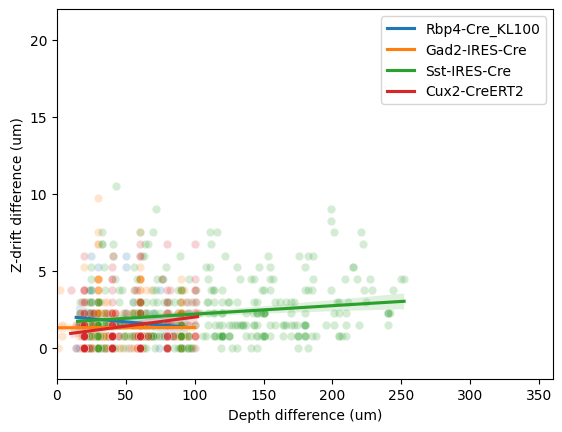

In [105]:
fig, ax = plt.subplots()
for cre_line in cre_lines:
    sns.regplot(omfish_depth_drift_df.query('cre_line==@cre_line'),
                x='depth_diff', y='zdrift_diff',
                ax=ax, scatter=False,
                label=cre_line)
    sns.scatterplot(omfish_depth_drift_df.query('cre_line==@cre_line'),
                x='depth_diff', y='zdrift_diff',
                ax=ax, label=None, legend=None,
                alpha=0.2)
ax.legend()
ax.set_xlabel('Depth difference (um)')
ax.set_ylabel('Z-drift difference (um)')
ax.set_ylim(-2, 22)
ax.set_xlim(0, 360)

In [89]:
omfish_depth_drift_df

,ophys_session_id,depth_diff,zdrift_diff,cre_line
0,1288252885,75,3.75,Rbp4-Cre_KL100
1,1288252885,50,2.25,Rbp4-Cre_KL100
2,1288252885,25,2.25,Rbp4-Cre_KL100
3,1288252885,25,6.00,Rbp4-Cre_KL100
4,1288252885,50,6.00,Rbp4-Cre_KL100
...,...,...,...,...
10,1258706332,20,0.00,Cux2-CreERT2
11,1258706332,60,0.00,Cux2-CreERT2
12,1258706332,60,0.00,Cux2-CreERT2
13,1258706332,20,0.00,Cux2-CreERT2


Text(0.5, 1.0, 'omFISH (no water restriction)')

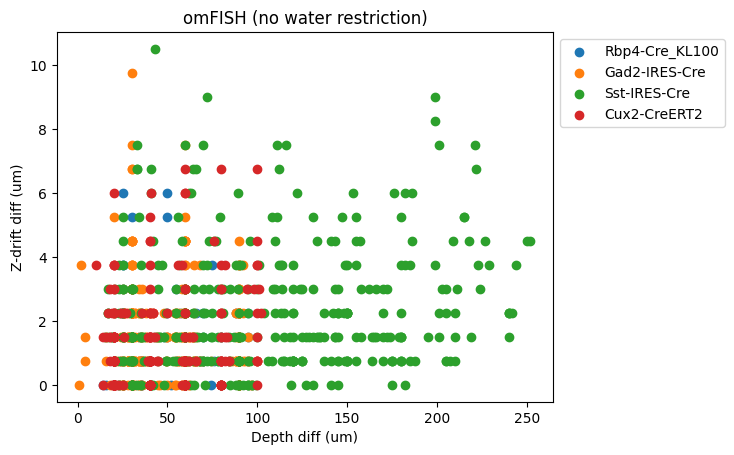

In [82]:
depth_bins = np.linspace(25,275,6)

cre_lines = omfish_table.cre_line.unique()
fig, ax = plt.subplots()
for crei, cre_line in enumerate(cre_lines):
    # cre_table = omfish_table.query('cre_line==@cre_line and targeted_structure=="VISl"')
    # depth_zdrift_pair = cre_table.groupby('osid').apply(lambda x: _return_depth_zdrift_diff_pair(x))
    cre_table = omfish_table.query('cre_line==@cre_line')
    depth_zdrift_pair = cre_table.groupby(['osid', 'targeted_structure']).apply(lambda x: _return_depth_zdrift_diff_pair(x))
    
    for i in range(len(depth_zdrift_pair)):
        depth_diff = depth_zdrift_pair.iloc[i][0]
        zdrift_diff = depth_zdrift_pair.iloc[i][1]
        
        if i == 0:
            ax.scatter(depth_diff, zdrift_diff, color=f'C{crei}', label=cre_line)
        else:
            ax.scatter(depth_diff, zdrift_diff, color=f'C{crei}')
ax.set_xlabel('Depth diff (um)')
ax.set_ylabel('Z-drift diff (um)')
ax.legend(loc='upper left', bbox_to_anchor=(1,1))
ax.set_title('omFISH (no water restriction)')


# Efficacy of global online motion correction for Slc17a7-Cre

In [107]:
exc_table.columns

Index(['oeid', 'depth', 'region', 'mpi_episodes', 'cc_episodes', 'mpi_fl',
       'cc_fl', 'osid', 'ophys_experiment_id', 'equipment_name',
       'full_genotype', 'cre_line', 'indicator', 'ophys_session_id',
       'project_code', 'imaging_depth', 'targeted_structure',
       'date_of_acquisition', 'session_type', 'config', 'water', 'mouse_id',
       'min_cc_episodes', 'min_cc_fl', 'zdrift_episodes', 'zdrift_fl'],
      dtype='object')

In [108]:
def get_zdrift_results_first_last(osid, load_dir):
    oeids = from_lims.get_ophys_experiment_ids_for_ophys_session_id(osid).ophys_experiment_id.values
    corrcoef = []
    matched_plane_indices = []
    for oeid in oeids:
        try:
            ocid = from_lims.get_ophys_container_id_for_ophys_experiment_id(oeid)
        except:
            ocid = 'none'
        zdrift_fn = load_dir / f'container_{ocid}' / f'experiment_{oeid}' / f'{oeid}_zdrift_ref_{oeid}_first_last.h5'
        with h5py.File(zdrift_fn) as h:
            corrcoef.append([np.max(cc) for cc in h['corrcoef'][:]])
            matched_plane_indices.append(h['matched_plane_indices'][:])
    return corrcoef, matched_plane_indices, oeids

In [109]:
zdrift_test_table = exc_table.groupby('ophys_session_id').apply(lambda x: len(x.targeted_structure.unique())==2)
osids = zdrift_test_table[zdrift_test_table].index.values
local_zstack_interval = 0.75
zdrift = []
corrected_zdrift = []
osid_list = []
for osid in osids:
    _, matched_plane_indices, _ = get_zdrift_results_first_last(osid, zdrift_dir)
    zdrift_session = local_zstack_interval * np.array([mpi[1] - mpi[0] for mpi in matched_plane_indices])
    corrected_zdrift_session = zdrift_session - zdrift_session.mean()
    zdrift.append(zdrift_session)
    corrected_zdrift.append(corrected_zdrift_session)
    osid_list.append(osid)

In [110]:
zdrift_all = np.concatenate(zdrift)
corrected_zdrift_all = np.concatenate(corrected_zdrift)

Text(0.5, 1.0, 'Slc17a7-Cre')

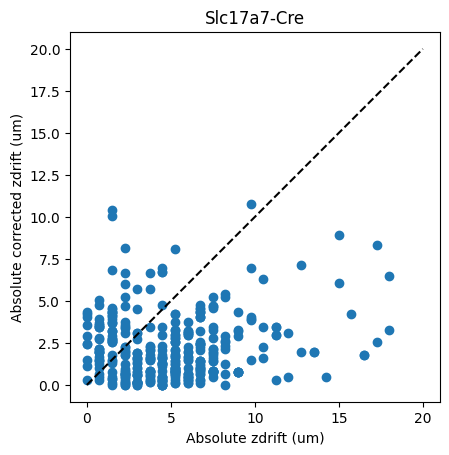

In [116]:
fig, ax = plt.subplots()
ax.scatter(abs(zdrift_all), abs(corrected_zdrift_all))
ax.plot([0, 20], [0, 20], 'k--')
ax.axis('square')
ax.set_xlabel('Absolute zdrift (um)')
ax.set_ylabel('Absolute corrected zdrift (um)')
ax.set_title('Slc17a7-Cre')

Text(0.5, 1.0, 'Slc17a7-Cre')

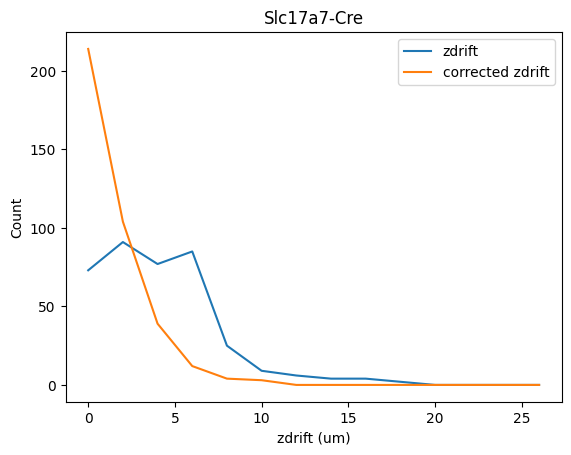

In [112]:
bins = np.arange(0,30,2)
fig, ax = plt.subplots()
ax.plot(bins[:-1], np.histogram(abs(zdrift_all), bins=bins)[0], label='zdrift')
ax.plot(bins[:-1], np.histogram(abs(corrected_zdrift_all), bins=bins)[0], label='corrected zdrift')
ax.legend()
ax.set_xlabel('zdrift (um)')
ax.set_ylabel('Count')
ax.set_title('Slc17a7-Cre')

Text(0.5, 1.0, 'Slc17a7-Cre')

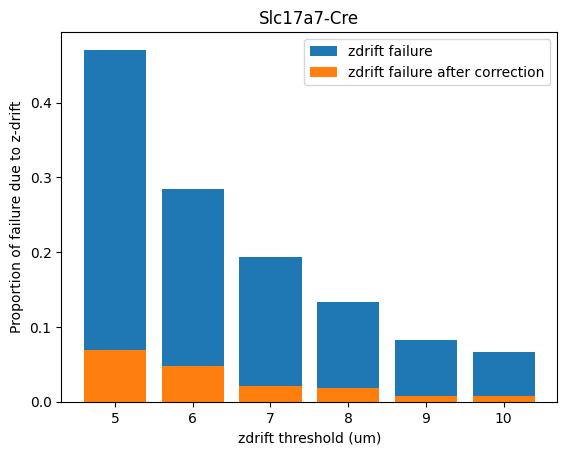

In [113]:
threshold_list = range(5,11)
prop_fail_list = []
prop_corrected_fail_list = []
for threshold in threshold_list:
    prop_fail = np.sum(abs(zdrift_all) > threshold) / len(zdrift_all)
    prop_corrected_fail = np.sum(abs(corrected_zdrift_all) > threshold) / len(corrected_zdrift_all)
    prop_fail_list.append(prop_fail)
    prop_corrected_fail_list.append(prop_corrected_fail)
    
fig, ax = plt.subplots()
ax.bar(threshold_list, prop_fail_list, label='zdrift failure')
ax.bar(threshold_list, prop_corrected_fail_list, label='zdrift failure after correction')
ax.legend()
ax.set_xlabel('zdrift threshold (um)')
ax.set_ylabel('Proportion of failure due to z-drift')
ax.set_title('Slc17a7-Cre')

In [114]:
prop_fail_list

[0.47074468085106386,
 0.2845744680851064,
 0.19414893617021275,
 0.13297872340425532,
 0.08244680851063829,
 0.06648936170212766]

In [117]:
prop_corrected_fail_list

[0.06914893617021277,
 0.047872340425531915,
 0.02127659574468085,
 0.018617021276595744,
 0.007978723404255319,
 0.007978723404255319]

# Correlation coefficient histogram

In [ ]:
bins = np.linspace(0,26,13)
fig, ax = plt.subplots()
# for cre_line in cre_lines:
#     zdrift = omfish_table.query('cre_line==@cre_line').zdrift_episodes.values
#     zdrift_density = np.histogram(zdrift, bins=bins)[0] / len(zdrift)
#     ax.plot(bins[:-1], zdrift_density)
    
    # ax.hist(zdrift, bins=bins, label=cre_line,
    #         alpha=0.5)
sns.histplot(omfish_table, x='zdrift_episodes', hue='cre_line',
             stat='proportion', ax=ax, common_norm=False)
# ax.legend()
ax.set_xlabel('Z-drift (um)')
# omfish_table['zdrift_episodes'].hist()


<AxesSubplot:>

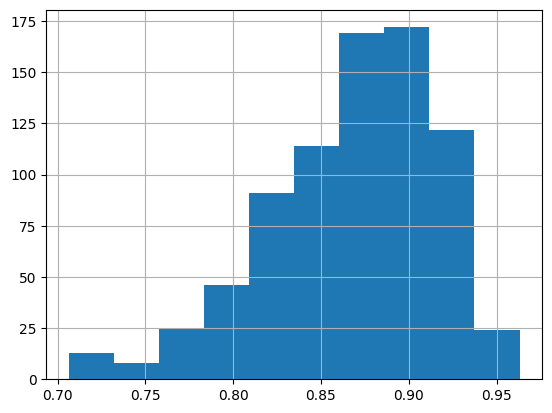

In [127]:
lamf_table.min_cc_episodes.hist()

<AxesSubplot:>

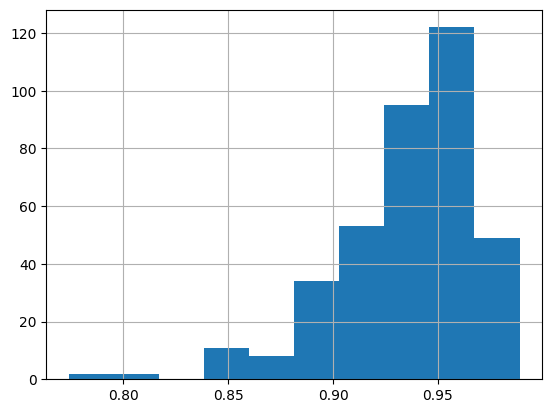

In [125]:
exc_table.min_cc_episodes

In [122]:
[min(v) for v in exc_table.cc_episodes.values]

[0.9074910750731768,
 0.9480497686433852,
 0.9401177389528089,
 0.9644955294965823,
 0.7979555278168275,
 0.9200458451322958,
 0.9056279360136349,
 0.9303052440259872,
 0.9167600549756195,
 0.9492466666555769,
 0.9414801088765822,
 0.9591574496621939,
 0.7739025261375669,
 0.8984211520464521,
 0.8972966296273126,
 0.9257274064385528,
 0.9139928773937925,
 0.9423441741381737,
 0.9459423343181041,
 0.9620706729959533,
 0.8162762242449069,
 0.8904437670946223,
 0.896662569029729,
 0.9136411545763775,
 0.9249203715656162,
 0.9469370620190517,
 0.9578773218822038,
 0.9586769514496157,
 0.8423593650583615,
 0.8943787303919347,
 0.9096454984358485,
 0.9271065298560482,
 0.9330250307934068,
 0.9110876594057673,
 0.9547330839287953,
 0.9573897669222042,
 0.9357147278888751,
 0.9069084076721253,
 0.936967255269416,
 0.9096231049212998,
 0.910571070599265,
 0.9424111927303769,
 0.8655864467653315,
 0.9028075902388759,
 0.9161830373085312,
 0.9478274717801108,
 0.9567590782455199,
 0.9152803845191